In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import get_img_obj_points
from utils import cal_undistort
from utils import *

import numpy as np
import glob
# Read in an image

fnames = glob.glob("camera_cal/*.jpg")

img_points_list = []
obj_points_list = []
for fname in fnames :
    img = cv2.imread(fname)
    nx = 9  # the number of inside corners in x
    ny = 6  # the number of inside corners in y
    img_points, obj_points = get_img_obj_points(img, nx, ny)
    img_points_list+=img_points
    obj_points_list+=obj_points



NameError: name 'image' is not defined

# Undistort

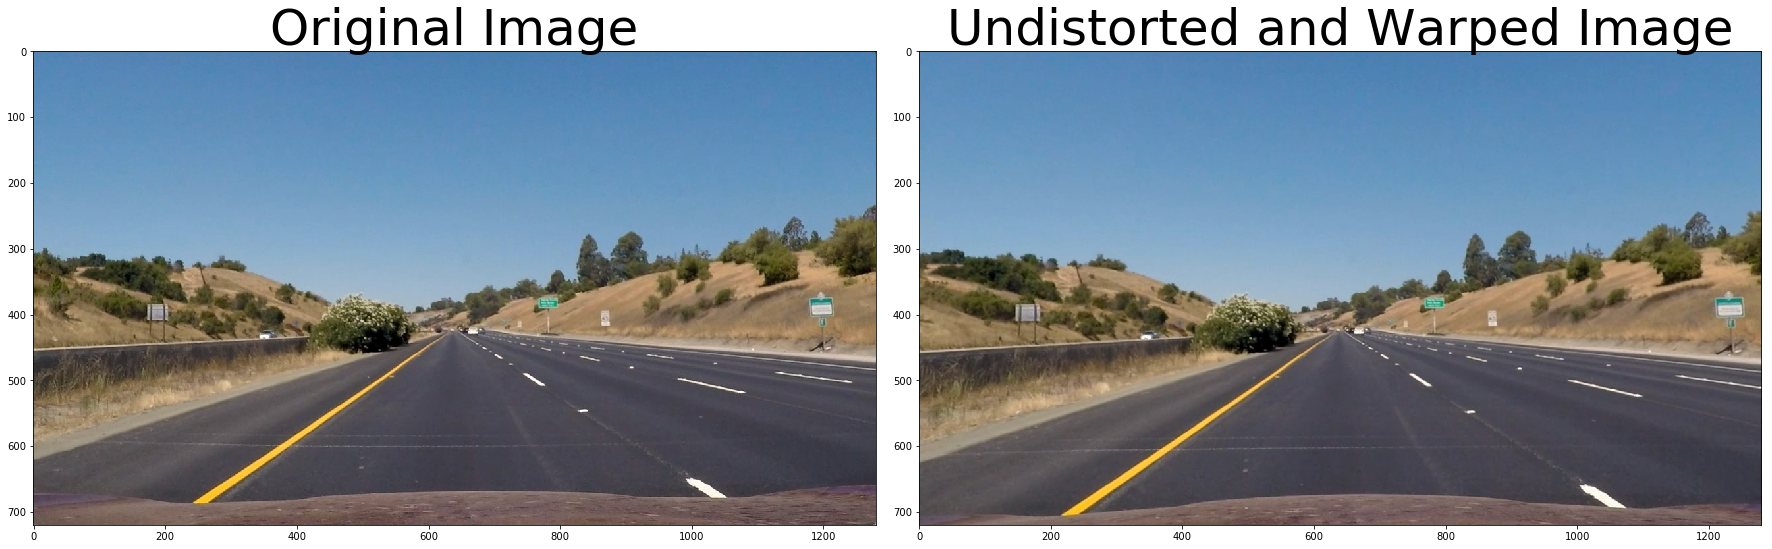

In [3]:
img = mpimg.imread('straight_lines1.jpg')
height, width  = img.shape[0], img.shape[1]
undistorted, dist, mtx = cal_undistort(img, obj_points_list, img_points_list)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# Sobel filters

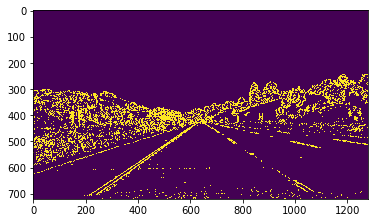

In [4]:
image = undistorted.copy()
combined = np.zeros((height,width), dtype = np.uint8)
combined_condition = sobel_filter(image)
combined[combined_condition] = 1
plt.imshow(combined)
plt.show()

# RGB Filter

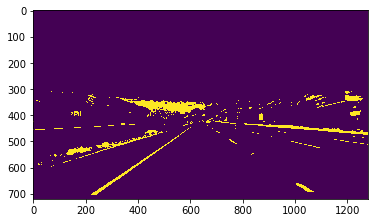

In [5]:
rgb = np.copy(undistorted)
color_combined = np.zeros((height,width), dtype = np.uint8)
r_g_condition = rgb_filter(rgb)
color_combined[r_g_condition] = 1
plt.imshow(color_combined)
plt.show()


# HLS filter

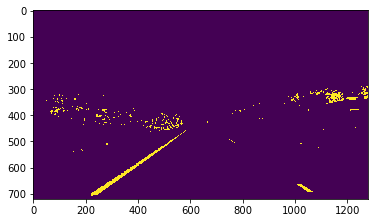

In [6]:
img = np.copy(undistorted)
s_binary = np.zeros((height,width), dtype = np.uint8)
s_binary_condition = hls_filter(img)
s_binary[s_binary_condition] = 1
plt.imshow(s_binary)
plt.show()

# Combined

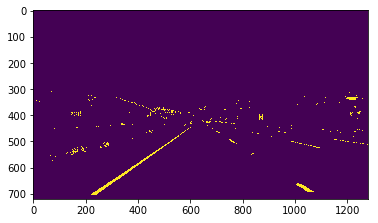

In [7]:
# Combine the two binary thresholds
combined_binary = np.zeros((height,width), dtype = np.uint8)
combined_binary[(r_g_condition ) & (s_binary_condition | combined_condition) ] = 1
plt.imshow(combined_binary)
plt.show()

# Region of intersect

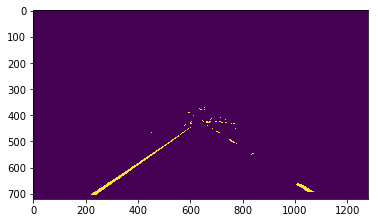

In [8]:

# apply the region of interest mask
mask = np.zeros_like(combined_binary)
region_of_intersect = np.array([[0,height], [width/2, int(0.5*height)], [width, height]], dtype=np.int32)
cv2.fillPoly(mask, [region_of_intersect], 1)
thresholded = cv2.bitwise_and(combined_binary, mask)

plt.imshow(thresholded)
plt.show()

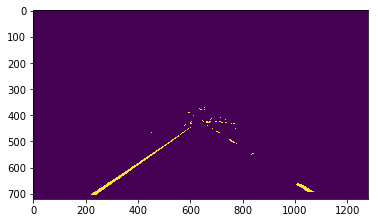

In [9]:
from utils import filter_image
filtered_image = filter_image(undistorted.copy())
plt.imshow(filtered_image)
plt.show()

# Perspective Transform

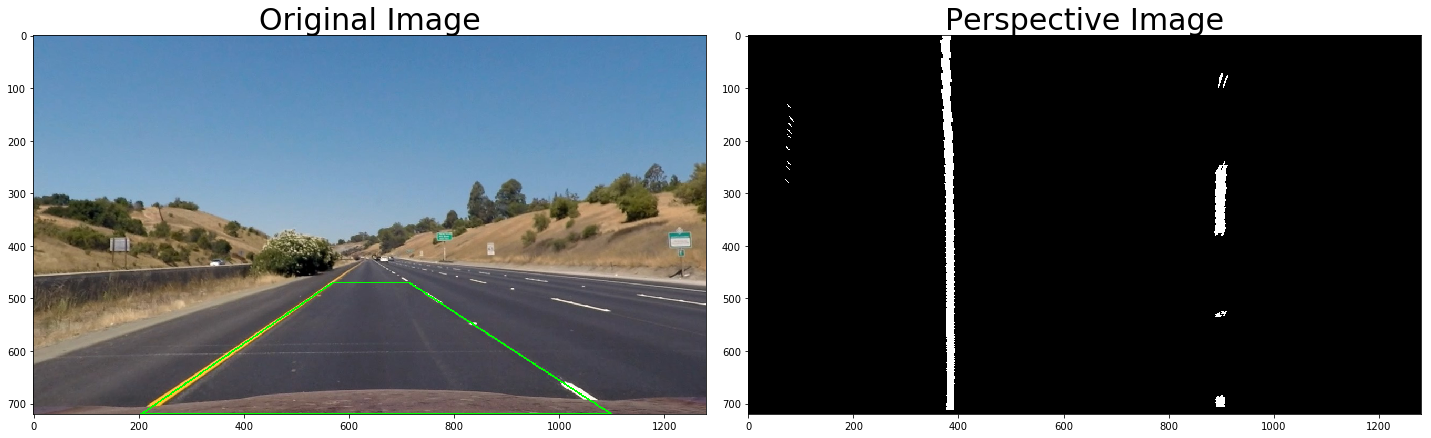

In [10]:
# # Vertices extracted manually for performing a perspective transform
warped, filled = perspective_transform_with_filled_area(img.copy(), filtered_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(filled)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Perspective Image', fontsize=30)
plt.show()


#### 

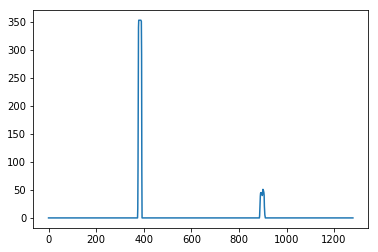

In [11]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

In [13]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

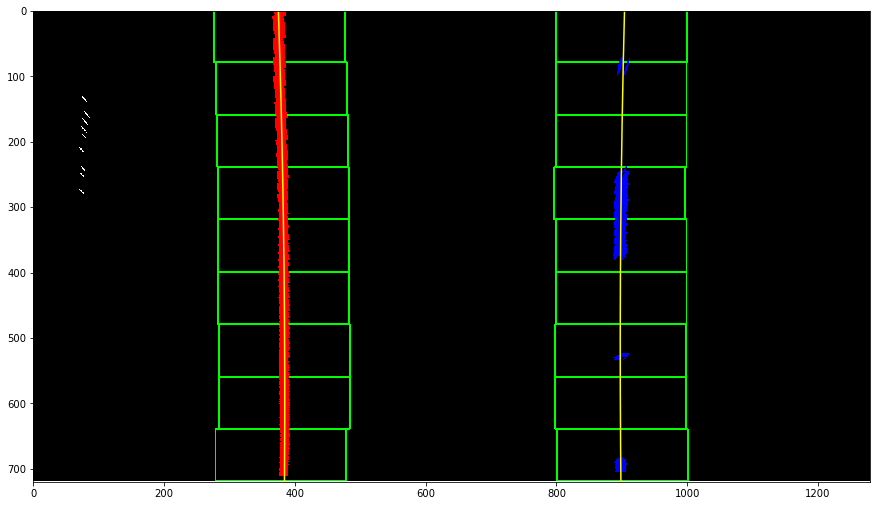

In [14]:
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.figure(figsize=(15,15))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

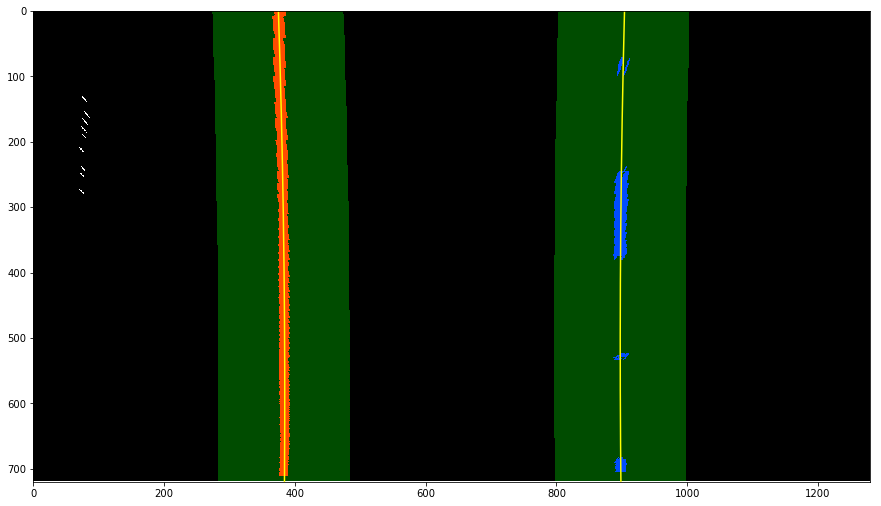

In [15]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.figure(figsize=(15,15))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [16]:
left_rad_curvature = get_curvature_radius(left_fit, ploty)
right_rad_curvature = get_curvature_radius(right_fit, ploty)
avg_rad_curvature = (left_rad_curvature+right_rad_curvature)/2
print('radius : ', avg_rad_curvature)

radius :  6269.315355123546


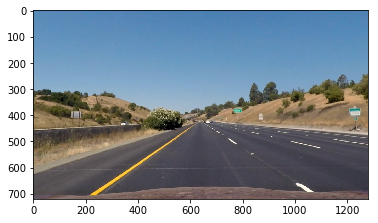

In [17]:
plt.imshow(img)
plt.show()

In [18]:
out_img = np.dstack((warped, warped, warped))*255

x1_min = left_fitx.min()
y1_min = height
x1_max  = left_fitx.max()
y1_max = 0

x2_min = right_fitx.max()
y2_min = height
x2_max  = right_fitx.min()
y2_max = 0

vertices = np.array([[x1_min, y1_min],[x1_max, y1_max], [x2_min, y2_max], [x2_max,y2_min]], np.int32)

cv2.fillPoly(out_img,[vertices],[0, 255, 0])

src = get_source_points()
dst = get_destination_points(height,width)
M_inverse = cv2.getPerspectiveTransform(dst, src)
unwarped = cv2.warpPerspective(out_img, M_inverse, img_size , flags=cv2.INTER_LINEAR)

result = cv2.addWeighted(img, 1, unwarped, 0.15, 0)
plt.figure(figsize=(15,15))
plt.imshow(result)

NameError: name 'dst' is not defined